In [1]:
# Import Python libraries (use Python >= v. 3.9.0)
#-------------------------------------------------

import networkx as nx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
import zipfile
import folium
import geojson

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from descartes import PolygonPatch
from shapely.geometry import Point
from shapely.ops import cascaded_union

In [2]:
# Download a geoJSON shapefile for the CB postcode areas (Cambridge, UK) from GitHub
#-----------------------------------------------------------------------------------
try:
    cb_geo_json_link =  'https://raw.githubusercontent.com/missinglink/uk-postcode-polygons/master/geojson/CB.geojson'
    cam_postcode_shapefile_r = urllib.request.urlopen(cb_geo_json_link)
    cam_postcode_shapefile = geojson.loads(cam_postcode_shapefile_r.read())
except:
    with open('data/cambridge.geosjon') as f:
        cam_postcode_shapefile = geojson.load(f)

In [3]:
# Create the a pandas dataframe which define 5 'central Cambridge' postcodes (to allow for these areas to be visualised in a differnt colour in the choropleth layer)
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------

central_list = []
postcodes = ["CB1", "CB2", "CB3", "CB4", "CB5"] #---------- the five postcodes defined as being 'central Cambridge'
geometry_list = cam_postcode_shapefile['features']
for geometry in geometry_list:
    if geometry['properties']['name'] in postcodes:
        data_cam = [geometry['properties']['name'],1] #---------- Central Postcodes asigned a value of 1 
        central_list.append(data_cam)
    else:
        data_cam = [geometry['properties']['name'],0] #---------- Other Postcodes asigned a value of 0
        central_list.append(data_cam)
post_code_df = pd.DataFrame(central_list, columns = ['Postcode', 'Central Cambridge']) 
post_code_df['Postcode'] = post_code_df['Postcode'].astype(str)

In [4]:
#Create a folium map visualising the areas covered by the Cambridge Postcodes
#----------------------------------------------------------------------------

#Defines the highlight and popup style for the choropleth layer
#--------------------------------------------------------------
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                           'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.5, 
                                 'weight': 0.1}

#Create the frame and background folium map 
#------------------------------------------
frame = folium.Figure(width=500, height=500) #------ Map centred on Cambridge using coordinates
cambridge_map = folium.Map(
    location=[52.21, 0.15], 
    tiles="cartodbpositron",
    zoom_start=9).add_to(frame)

#Add a choropleth with the Cambridge postcode areas (with central postcodes differently coloured using the post_code_df)
#------------------------------------------------------------------------------------------------------------------------
chloro = folium.Choropleth(
    geo_data= cam_postcode_shapefile,
    data=post_code_df,
    name = 'Cambridge Postcodes',
    columns= ['Postcode', 'Central Cambridge'],
    key_on='feature.properties.name',
    fill_color="RdBu",
    fill_opacity=0.7,
    line_opacity=1,
    highlight = True,
   )

#Adding a toolip which appears on hover to the postcode choropleth layer
#----------------------------------------------------------------------
data_on_hover = folium.features.GeoJson(data = cam_postcode_shapefile, style_function=style_function, control=False, highlight_function=highlight_function, tooltip=folium.features.GeoJsonTooltip(
    fields= ['name'], 
    aliases=['Postcode: '],
    localize = True))

#Removes the automatically generated folium legend from the map
#--------------------------------------------------------------
for key in chloro._children:
    if key.startswith('color_map'):
        del(chloro._children[key])
#--------------------------------------------------------------

cambridge_map.add_child(data_on_hover)
cambridge_map.keep_in_front(data_on_hover)
chloro.add_to(cambridge_map)
folium.LayerControl().add_to(cambridge_map)

#Saves the folium map as an html object for use in the webpage
#--------------------------------------------------------------
cambridge_map.save('images/folium/cambridge_postcode_map.html', "w")

In [5]:
# EPRACCUR GP Practice data ingestion
#-----------------------------------------

# Retrieves and saves the most recent EPRACCUR dataset from NHS Digital webpage
#------------------------------------------------------------------------------
url = 'https://files.digital.nhs.uk/assets/ods/current/epraccur.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
first_file = zip_file_object.namelist()[0]
file = zip_file_object.open(first_file)
content = file.read()
csv_file = open('data/epraccur_data.csv', 'wb') #-------------- saves the data to the GitHub Repo
csv_file.write(content)
csv_file.close()
header_list = ["Organisation Code", "Name", "National Grouping", "High Level Health Geography", "Address line 1", "Address line 2", "Address line 3", 
"Address line 4", "Address line 5","Postcode","Open Date","Close Date","Status Code","Organisation Sub-Type Code","Commissioner","Join Provider/Purchaser Date",
"Left Provider/Purchaser Date","Contact Telephone Number", "Null 1", "Null 2", "Null 3", "Amended Record Indicator", "Null 4", "Provider/Purchaser",
"Null 5", "Prescribing Setting", "Null 6"] #--------------- Column names are not in the raw data, passed to pandas using the header_list
 
# GP Practice Data Processing
#-----------------------------------------
gp_practice_df = pd.read_csv('data/epraccur_data.csv', names=header_list)
gp_practice_df = gp_practice_df[(gp_practice_df["Status Code"] == "A") & (gp_practice_df["Prescribing Setting"] == 4) #----------- Selecting only Active and Standard GP Practices form the data
& (gp_practice_df["Postcode"].str.contains('CB1 |CB2 |CB3 |CB4 |CB5 '))].reset_index(drop = True) #----------- Central cambridge defined as having the following postcodes: CB1, CB2, CB3, CB4, CB5
gp_practice_df['Full Address'] = gp_practice_df[['Address line 2', 'Address line 3', 'Address line 4',]].astype(str).agg(', '.join, axis=1) #------- Joining the address data from various columns to get a full address
gp_practice_df['Full Address'] = gp_practice_df['Full Address'].str.title() + ', ' + gp_practice_df['Postcode'] 
gp_practice_df['Full Address'] = gp_practice_df['Full Address'].str.replace('Nan', '').str.replace(' ,', ' ')
gp_practice_df['Name'] = gp_practice_df['Name'].str.title()
gp_practice_df_1 = gp_practice_df[['Organisation Code', 'Name', 'Full Address', 'Postcode', 'Contact Telephone Number']]

In [6]:

# Geolocation of GP practices in Cambridge using GeoPy and the Nomatin API using their postcodes
#-----------------------------------------------------------------------------------------------
gp_practice_df_saved = pd.read_csv('data/cambridge_gp_practices.csv', index_col = 0)
new_list = list(gp_practice_df_1['Organisation Code'])
saved_list = list(gp_practice_df_saved['Organisation Code'])
new_orgs = list(set(new_list) - (set(saved_list))) #------------- Geocoding only occurs if new GP practices in Central Cambridge added to the EPRACCUR dataset
if new_orgs:
    geolocator = Nominatim(user_agent="open_access_nhs") #------------- Setting Nominatim as the API to use during postcode geolocation
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1) #--------- Rate limiting to 1 query per second
    gp_practice_df_1["location"] = gp_practice_df_1["Postcode"].apply(geolocator.geocode)
    gp_practice_df_1["Point"] = gp_practice_df_1["location"].apply(lambda loc: tuple(loc.point) if loc else None)
    gp_practice_df_1[['Latitude', 'Longitude', 'Altitude']] = gp_practice_df_1['Point'].to_list()
    gp_practice_df_2 = gp_practice_df_1[["Organisation Code","Name", "Full Address", "Postcode", "Contact Telephone Number", "Latitude", "Longitude"]]
    gp_practice_df_2.to_csv('data/cambridge_gp_practices.csv') #--------- If new GP practices in the latest EPRACCUR dataset, save a new geocoded Cambridge GP Practice dataset
else:
    gp_practice_df_2 = gp_practice_df_saved.copy()
    print('No new cambridge GP practices')

No new cambridge GP practices


In [7]:
# Map visualisation of Cambridge GP practices with Postcode area geoJSON
#-----------------------------------------------------------------------
frame = folium.Figure(width=600, height=600)
folium_fig = folium.Map(
    location=[52.21, 0.15],
    tiles="cartodbpositron",
    zoom_start=12).add_to(frame)

#Add markers for each of the Cambridge GP practices with contact and location information added as part of a popup
#-----------------------------------------------------------------------------------------------------------------
for code, name, address, number, lat, lon in zip(gp_practice_df_2['Organisation Code'],
gp_practice_df_2['Name'],
gp_practice_df_2['Full Address'],
gp_practice_df_2['Contact Telephone Number'],
gp_practice_df_2['Latitude'],
gp_practice_df_2['Longitude']):
    folium.Marker(
        [lat, lon],
        popup = folium.Popup('<b>' + 'Name: ' + '</b>'  + str(name) + '<br>'
        '<b>' + 'GP Practice Code: ' + '</b>' + str(code) + '<br>'
        '<b>' + 'Address: ' + '</b>' + str(address) + '<br>'
        '<b>' + 'Telephone Number: ' + '</b>' + str(number) + '<br>',
        max_width=len(address)*20),
        icon=folium.Icon(color="darkblue", prefix='fa', icon="fa-medkit"),
        ).add_to(folium_fig)

#Add a choropleth with the Cambridge postcode areas (with central postcodes differently coloured using the post_code_df)
#------------------------------------------------------------------------------------------------------------------------
chloro = folium.Choropleth(
    geo_data= cam_postcode_shapefile,
    data=post_code_df,
    name = 'Cambridge Postcodes',
    columns= ['Postcode', 'Central Cambridge'],
    key_on='feature.properties.name',
    fill_color="RdBu",
    fill_opacity=0.1,
    line_opacity=1,
   )
for key in chloro._children:
    if key.startswith('color_map'):
        del(chloro._children[key])
chloro.add_to(folium_fig)
folium_fig
folium.LayerControl().add_to(folium_fig)

#Saves the folium map as an html object for use in the webpage
#-----------------------------------------------------------------
folium_fig.save("images/folium/cambridge_map_no_travel.html", "w")

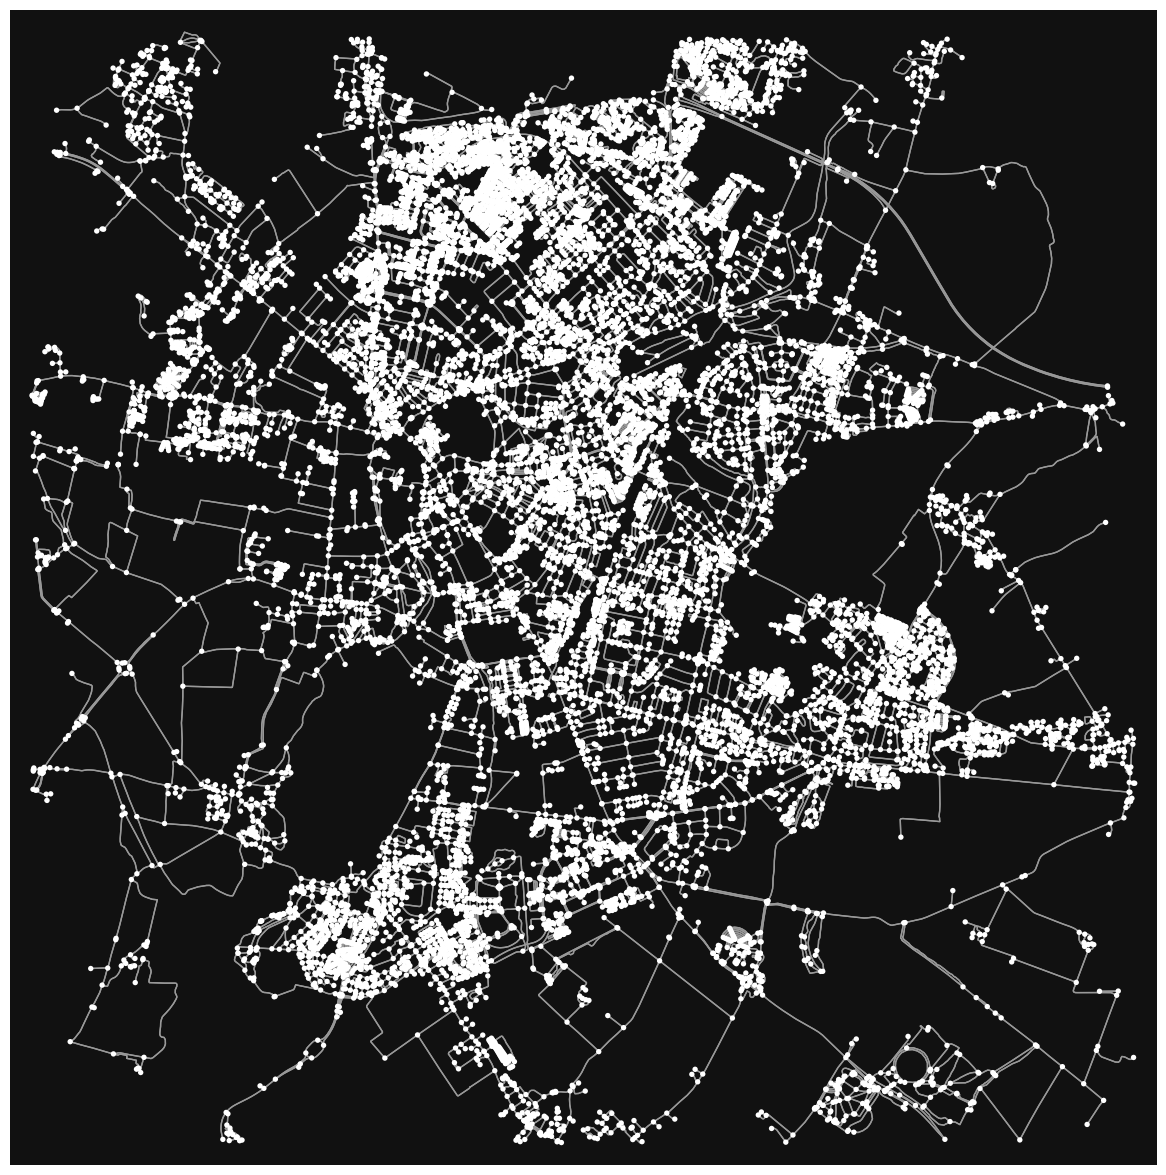

In [8]:
#Time of travel (walking) analysis for GP practices in central Cambridge (5000 meters from centre)
#--------------------------------------------------------------------------------------------------

#Create a OSMnx walkable urban network graph 5000 meters point arbitrarily defined as the centre of Cambridge
#-------------------------------------------------------------------------------------------------------------
place = "Cambridge, England"
mode = "walk"
G = ox.graph_from_address(place, dist = 5000, simplify=True, network_type=mode)
fig, ax = ox.plot_graph(G, figsize = (15,15));

In [9]:
# Map the coordinates of each of the central Cambridge GP practices to the nearest node on OSMnx walkable urban network graph
#----------------------------------------------------------------------------------------------------------------------------
point_of_interest = ox.distance.nearest_nodes(G, X = gp_practice_df_2['Longitude'], Y=gp_practice_df_2['Latitude']) #---- X = longitude, Y = Latitude 

In [10]:
 
#Defining trip times of interest, walking speed, and adding and edge attribute 'time' to each edge in urban network graph
#---------------------------------------------------------------------------------------------------------------------------

# Trip time in Mintues
#----------------------
trip_times = [5,10,20]

# walking speed in km/hour
#-------------------------
travel_speed = 4.5

# add an edge attribute for time in minutes required to traverse each edge
#--------------------------------------------------------------------------
meters_per_minute = travel_speed * 1000 / 60 # convert speed in km per hour to meteres per minute as length attribute in edges sorted in metres and travel time specified in minutes
for _, _, _, data in G.edges(data=True, keys=True):  
    data['time'] = data['length'] / meters_per_minute

#---------------
# u,v,k refer to the unique indentifiers of an edge in a network graph. u and v are the two nodes the edege connects while the k, is the key attribute which differentiates between parallel edges. 
# data refers to edge attributes - these include length, osmid, oneway and others

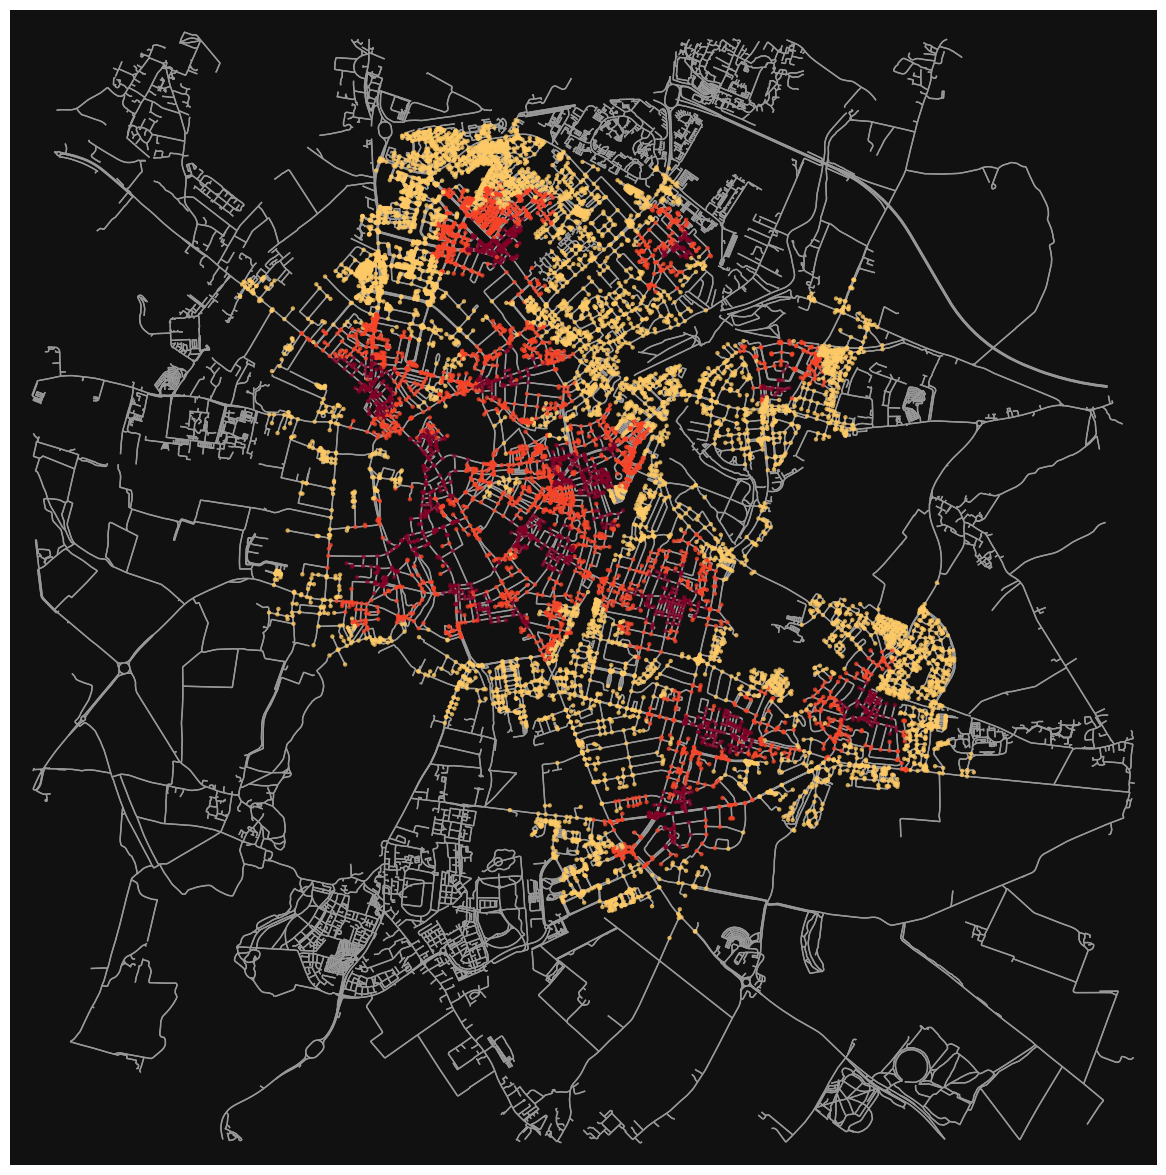

In [11]:
# Return one color for each isochrone (each of the trip times) 
#-------------------------------------------------------------
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='YlOrRd', start=0.3, return_hex=True)

# Color the nodes according to isochrone then plot the urban network graph
#--------------------------------------------------------------------------
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    for point in point_of_interest:
        subgraph = nx.ego_graph(G, point, radius=trip_time, distance='time') #---- uses the edge attribute 'time' to define the isochrones for each of the trips
        for node in subgraph.nodes():
            node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [10 if node in node_colors else 0 for node in G.nodes()] #------ sets the size of the coloured nodes at '10', while uncoloured nodes (outside trip times) are not visualised
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2, figsize = (15,15))

/opt/homebrew/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


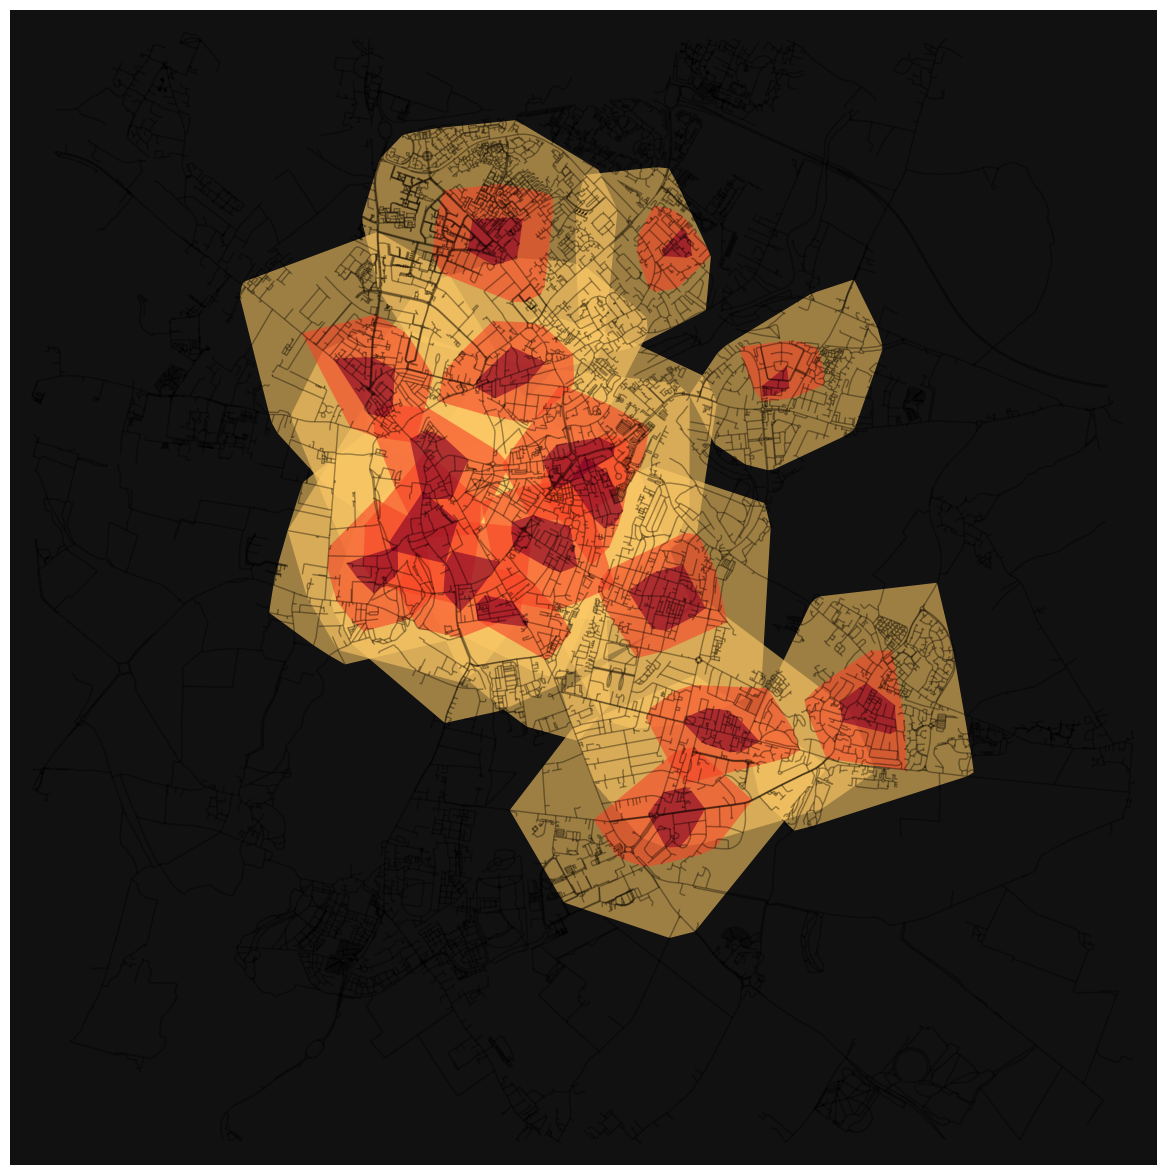

In [12]:
# Generate isochrone polygons (convex hull) using GeoPandas and NetworkX for each of the GP practice isochrones 
#--------------------------------------------------------------------------------------------------------------
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    isochrone_polys_sub = []
    for point in point_of_interest:
        subgraph = nx.ego_graph(G, point, radius=trip_time, distance='time')
        node_points = [Point((data['x'], data['y'])) for _, data in subgraph.nodes(data=True)] 
        bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
        isochrone_polys_sub.append(bounding_poly)
    isochrone_polys.append(isochrone_polys_sub)

# Plot the network then add isochrones as colored descartes polygon patches
#-----------------------------------------------------------------------
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none', figsize = (15,15))
for polygon, fc in zip(isochrone_polys, iso_colors):
    for subpolygon in polygon:
        patch = PolygonPatch(subpolygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
plt.show()

In [13]:
# Generate three isochrone GeoJSON files representing the areas 5 minutes, 10 minutes, and 20 minutes 
# walking distance from any of the central Cambridge GP practices from the ischrone polygons and add 
# the to a folium map
#-------------------------------------------------------------------------------------------------
frame = folium.Figure(width=600, height=600)
folium_fig = folium.Map(
    location=[52.21, 0.15],
    tiles="cartodbpositron",
    zoom_start=12).add_to(frame)

for code, name, address, number, lat, lon in zip(gp_practice_df_2['Organisation Code'],
gp_practice_df_2['Name'],
gp_practice_df_2['Full Address'],
gp_practice_df_2['Contact Telephone Number'],
gp_practice_df_2['Latitude'],
gp_practice_df_2['Longitude']):
    folium.Marker(
        [lat, lon],
        popup = folium.Popup('<b>' + 'Name: ' + '</b>'  + str(name) + '<br>'
        '<b>' + 'GP Practice Code: ' + '</b>' + str(code) + '<br>'
        '<b>' + 'Address: ' + '</b>' + str(address) + '<br>'
        '<b>' + 'Telephone Number: ' + '</b>' + str(number) + '<br>',
        max_width=len(address)*20),
        icon=folium.Icon(color="darkblue", prefix='fa', icon="fa-medkit"),
        ).add_to(folium_fig)

#Set the style for each of the ischrone geoJSONs
#--------------------------------------------------------
style_geojson = [
{'shape_name': '20 min walk','shape_fillColor': '#003087'},
{'shape_name': '10 min walk', 'shape_fillColor': '#005EB8'},
{'shape_name': '5 min walk', 'shape_fillColor': '#41B6E6'}]

# From each of the isochrone polygons generate at geoJSON shapefile and add it to a folium map at the same time
#-------------------------------------------------------------------------------------------------------------
gdf_index = list(gp_practice_df_2.index)
for polygon, style in zip(isochrone_polys, style_geojson):
     gdf = gpd.GeoDataFrame({"GP Practice": gdf_index}, geometry= polygon)
     polygon_json = list(gdf['geometry'])
     geojson = gpd.GeoSeries(polygon_json).unary_union
     fillColor = style['shape_fillColor']
     shape_name = style['shape_name']
     folium.GeoJson(geojson, name = shape_name, style_function = lambda x, fillColor = fillColor: {
            "fillColor": fillColor,
            "name":  shape_name,
            "weight": 1,
            "fillOpacity": 0.5,
            "color": "#000000"
            }).add_to(folium_fig)
folium.LayerControl().add_to(folium_fig)

#Saves the folium map as an html object for use in the webpage
#--------------------------------------------------------------
folium_fig.save("images/folium/cambridge_map_travel.html", "w")